In [1]:
import sys
import torch
import torch.nn.functional as F
from transformers import RobertaTokenizer

from meter.config import ex
from meter.modules import METERTransformerSS
from meter.datamodules.multitask_datamodule import MTDataModule
from meter.datamodules.vqav2_datamodule import VQAv2DataModule
from meter.modules.utils import unnormalize_image
import matplotlib.pyplot as plt

%matplotlib inline

## Config

In [2]:
ckpt_url = 'https://berkeley.box.com/shared/static/yv1cqa7ydhrh31dxz97yaykxqbq40wpl.ckpt'
data_root = '/shared/bfshi/dataset/METER/'   # change this to your own data root

In [3]:
@ex.main
def run():
    pass

_ = ex.run(named_configs=['task_finetune_vqa_clip_bert', 'absvit_base_patch16_224', 'text_roberta'],
           config_updates={'data_root': data_root})
config = _.config

WARNING - root - Changed type of config entry "max_steps" from int to NoneType
WARNING - METER - No observers have been added to this run
INFO - METER - Running command 'run'
INFO - METER - Started
INFO - METER - Completed after 0:00:00


## Load Data and Model

In [33]:
dm = VQAv2DataModule(config)
model = METERTransformerSS(config)

checkpoint = torch.utils.model_zoo.load_url(ckpt_url)
model.load_state_dict(checkpoint['state_dict'])
_ = model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [6]:
dm.setup('fit')

## Choose An Image From The Dataset

In [7]:
data = dm.val_dataset[150]

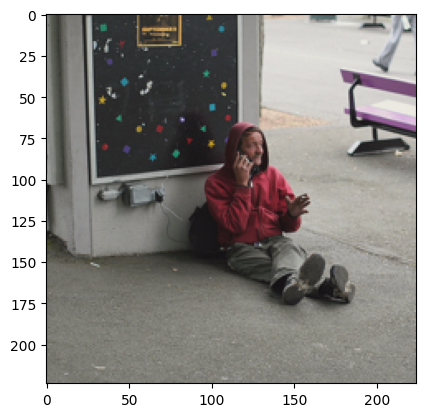

In [17]:
img = unnormalize_image(data['image'][0].cuda())
plt.imshow(img)

In [9]:
@torch.no_grad()
def forward_att_vis(self, x, prompt_=None):
    input = x
    x, _, __ = self.forward_features(input)

    prompt = self.prompt_decoder(prompt_)
    cos_sim = F.normalize(x, dim=-1) @ F.normalize(prompt[..., None], dim=1)
    mask = cos_sim.clamp(0, 1)
    x = x * mask
    top_down_transform = prompt[..., None] @ prompt[..., None].transpose(-1, -2)
    x = x @ top_down_transform * 5
    td = self.feedback(x)

    output, att, in_var, out_var = self.forward_features_att_vis(input, td)

    return att, mask[:, 1:]


In [10]:
def get_prompt(question):
    input_ids = tokenizer(question)['input_ids']
    text_masks = tokenizer(question)['attention_mask']
    input_ids = torch.LongTensor(input_ids)[None]
    text_embeds = model.text_transformer.embeddings(input_ids=input_ids)
    device = text_embeds.device
    text_masks = torch.LongTensor(text_masks)[None]
    input_shape = text_masks.size()
    extend_text_masks = model.text_transformer.get_extended_attention_mask(text_masks, input_shape, device)
    for layer in model.text_transformer.encoder.layer:
        text_embeds = layer(text_embeds, extend_text_masks)[0]
    prompt = text_embeds.mean(dim=1)
    return prompt


## Question 1: What color is the man's jacket?


Question: What color is the man's jacket?


<Figure size 640x480 with 0 Axes>

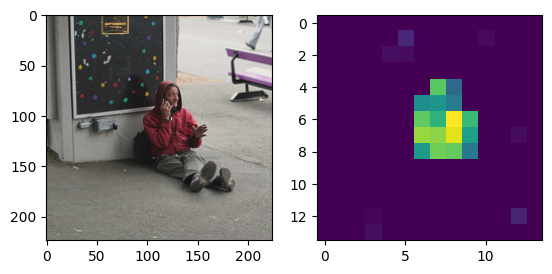

In [34]:
question = "What color is the man's jacket?"

input_img = data['image'][0][None]
prompt = get_prompt(question)
att, mask = forward_att_vis(model.vit_model, input_img, prompt_=prompt)
att = (att - (0.5 * att.max() + 0.5 * att.min())).clamp(0, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
print(f"Question: {question}")
axarr[0].imshow(img)
axarr[1].imshow(att[0].view(14, 14).detach().numpy())

## Question 2: What color is the bench?

Question: What color is the bench?


<Figure size 640x480 with 0 Axes>

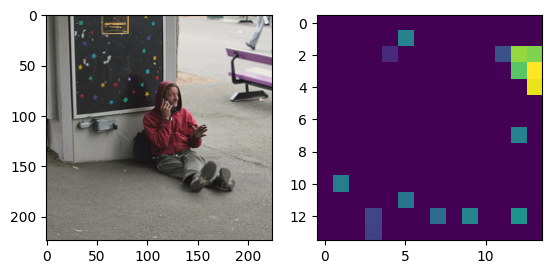

In [35]:
question = "What color is the bench?"

input_img = data['image'][0][None]
prompt = get_prompt(question)
att, mask = forward_att_vis(model.vit_model, input_img, prompt_=prompt)
att = (att - (0.5 * att.max() + 0.5 * att.min())).clamp(0, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
print(f"Question: {question}")
axarr[0].imshow(img)
axarr[1].imshow(att[0].view(14, 14).detach().numpy())

## Question 3: What is the man doing?

Question: What is the man doing?


<Figure size 640x480 with 0 Axes>

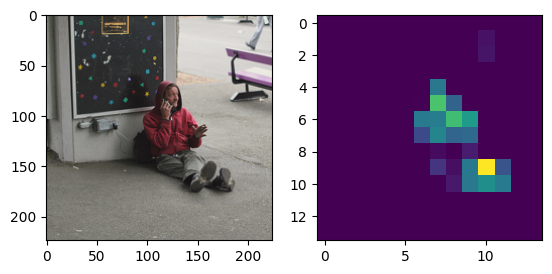

In [36]:
question = "What is the man doing?"

input_img = data['image'][0][None]
prompt = get_prompt(question)
att, mask = forward_att_vis(model.vit_model, input_img, prompt_=prompt)
att = (att - (0.5 * att.max() + 0.5 * att.min())).clamp(0, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
print(f"Question: {question}")
axarr[0].imshow(img)
axarr[1].imshow(att[0].view(14, 14).detach().numpy())

## Question 4: Is the man charging his phone?

Question: Is the man charging his phone?


<Figure size 640x480 with 0 Axes>

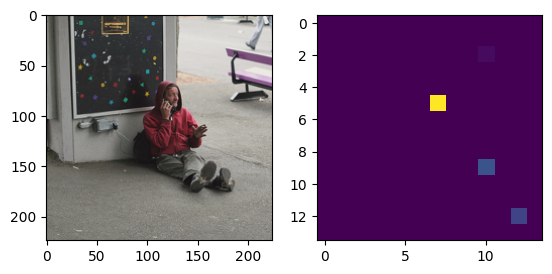

In [37]:
question = "Is the man charging his phone?"

input_img = data['image'][0][None]
prompt = get_prompt(question)
att, mask = forward_att_vis(model.vit_model, input_img, prompt_=prompt)
att = (att - (0.5 * att.max() + 0.5 * att.min())).clamp(0, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
print(f"Question: {question}")
axarr[0].imshow(img)
axarr[1].imshow(att[0].view(14, 14).detach().numpy())